In [1]:
from IPython.display import display
from ipyfilechooser import FileChooser


RESULTS_PATH = '/home/adriana/Documents/master/hands_on_recommender_systems/Project/data/ego-twitter/results'

def select_dir(fc):
    global RESULTS_PATH
    RESULTS_PATH = fc.selected

fc = FileChooser(RESULTS_PATH)
fc.register_callback(select_dir)
fc.show_only_dirs = True
fc.title = '<b>Please chose the folder where results are located</b>'

display(fc)

FileChooser(path='/home/adriana/Documents/master/hands_on_recommender_systems/Project/data/ego-twitter/results…

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

from sklearn.metrics import auc
from models import MODELS, NORMALIZATION_METHODS
from io_helpers.readers import read_ndarray_from_file
from ego_network import get_ego_ids


ego_network_ids = get_ego_ids(RESULTS_PATH, order_by_edges_size=False)
results = {}
best_results_per_ego_network_id = {}
best_results_per_model = {}

for model in MODELS:
    for normalization_method in NORMALIZATION_METHODS:
        best_results_per_model[f'{model.display_name}_{normalization_method}'] = 0

for ego_network_id in ego_network_ids:
    results[ego_network_id] = {}
    best_results_per_ego_network_id[ego_network_id] = {
        'model': None,
        'normalization_method': None,
        'roc_auc': None
    }
    for model in MODELS:
        results[ego_network_id][model.display_name] = {}
        for normalization_method in NORMALIZATION_METHODS:
            results_directory_for_id = os.path.join(RESULTS_PATH, str(ego_network_id))
            try:
                fpr = read_ndarray_from_file(os.path.join(results_directory_for_id, f'{model.file_prefix}_{normalization_method}.fpr'))
                tpr = read_ndarray_from_file(os.path.join(results_directory_for_id, f'{model.file_prefix}_{normalization_method}.tpr'))
            except:
                continue
            
            roc_auc = auc(fpr, tpr)
            results[ego_network_id][model.display_name][normalization_method] = roc_auc
            if best_results_per_ego_network_id[ego_network_id]['roc_auc'] is None or best_results_per_ego_network_id[ego_network_id]['roc_auc'] < roc_auc:
                best_results_per_ego_network_id[ego_network_id]['model'] = model.display_name
                best_results_per_ego_network_id[ego_network_id]['normalization_method'] = normalization_method
                best_results_per_ego_network_id[ego_network_id]['roc_auc'] = roc_auc
    best_model = best_results_per_ego_network_id[ego_network_id]['model']
    best_normalization_method = best_results_per_ego_network_id[ego_network_id]['normalization_method']
    if best_model:
        best_results_per_model[f'{best_model}_{best_normalization_method}'] += 1

best_results_per_model = dict(sorted(best_results_per_model.items(), key=lambda item: item[1], reverse=True))

/home/adriana/.local/lib/python3.8/site-packages/spacy/language.py:1895: UserWarning: [W123] Argument disable with value [] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  warnings.warn(
/home/adriana/Documents/master/hands_on_recommender_systems/Project/io_helpers/readers.py:7: UserWarning: loadtxt: Empty input file: "<_io.TextIOWrapper name='/home/adriana/Documents/master/hands_on_recommender_systems/Project/data/ego-twitter/results/14711172/tc_n_l1.fpr' mode='r' encoding='UTF-8'>"
  return numpy.loadtxt(file)


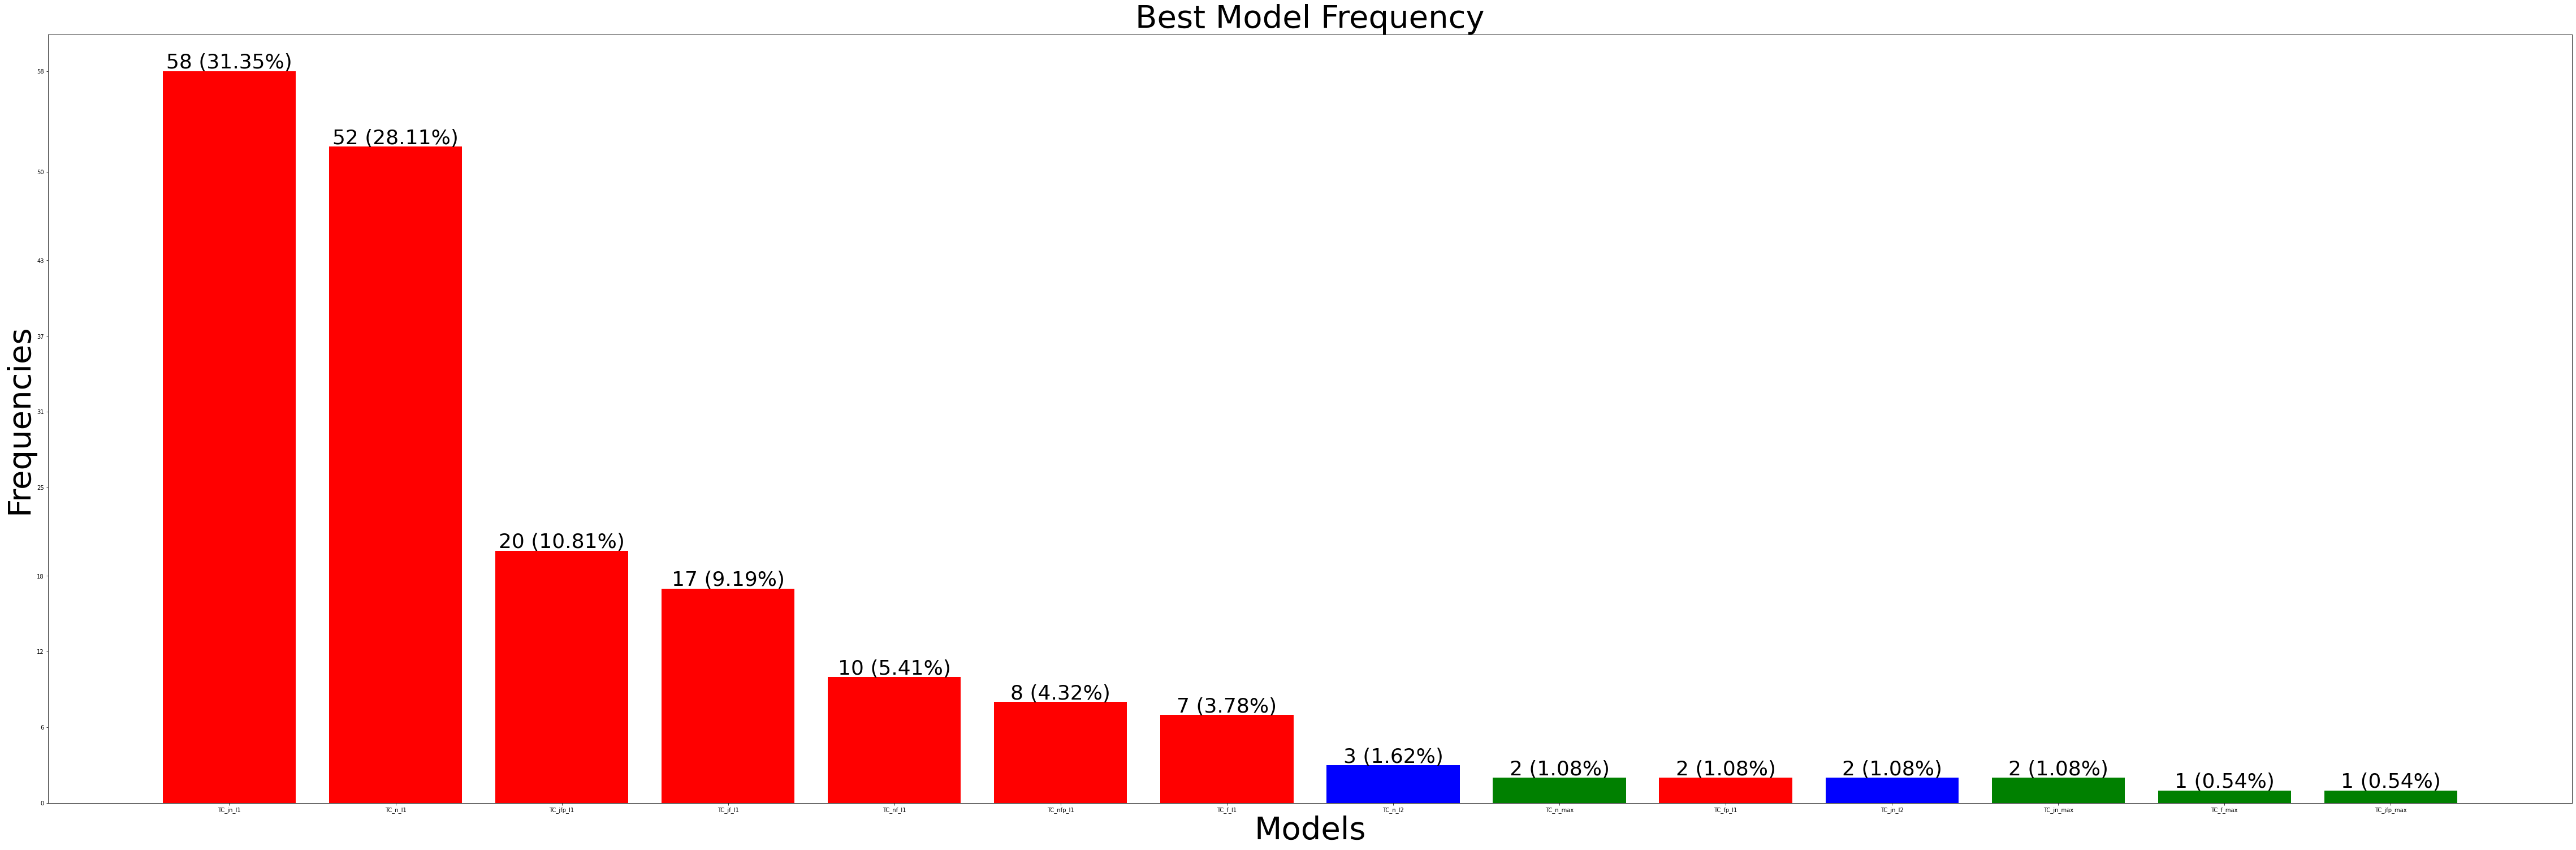

Number of evaluated ego networks: 185


In [4]:
import matplotlib.pyplot as plt
import numpy as np


FONT_SIZE = 56
TICKS_FONT_SIZE = 36
MODEL_COLOR_MAP = {'l1': 'red', 'l2': 'blue', 'max': 'green'}

def generate_plot(models, values, title, omit_if_empty=True):
    fig, ax = plt.subplots(figsize=(80,25))

    if omit_if_empty:
        values = [value for value in values if value > 0]
        models = models[:len(values)]

    ego_network_ids_with_results = 0
    for value in values:
        ego_network_ids_with_results += value

    bar_colors = [MODEL_COLOR_MAP[model.split('_')[-1]] for model in models]
    ax.bar(models, values, color=bar_colors)

    ax.set_title(title, fontsize=FONT_SIZE)

    max_value = values[0]
    number_of_yticks = 10
    yticks = list(np.linspace(0, number_of_yticks * int(max_value/number_of_yticks), min(max_value + 1, number_of_yticks - 1), dtype=int))
    if max_value not in yticks:
        yticks = yticks + [max_value]
    ax.set_yticks(yticks, fontsize=TICKS_FONT_SIZE)
    ax.set_xlabel('Models', fontsize=FONT_SIZE)
    ax.set_ylabel('Frequencies',  fontsize=FONT_SIZE)
    
    for index in range(len(models)):
        # label = f'{values[index]} ({values[index]*100/ego_network_ids_with_results}%)'
        label = '{:n} ({:.2f}%)'.format(values[index], values[index]*100/ego_network_ids_with_results)
        plt.text(index, values[index] + 0.2, label, ha='center', fontdict={'size': TICKS_FONT_SIZE})

    plt.rc('font', size=FONT_SIZE)   
    plt.rc('axes', titlesize=FONT_SIZE)
    plt.rc('axes', labelsize=TICKS_FONT_SIZE)
    plt.rc('xtick', labelsize=TICKS_FONT_SIZE)
    plt.rc('ytick', labelsize=TICKS_FONT_SIZE)
    plt.rc('legend', fontsize=FONT_SIZE)
    plt.rc('figure', titlesize=FONT_SIZE)

    plt.show()

    print(f'Number of evaluated ego networks: {ego_network_ids_with_results}')
    

models = list(best_results_per_model.keys())
values = list(best_results_per_model.values())
generate_plot(models, values, 'Best Model Frequency')